In [8]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data and calculate GF

In [2]:
#define our output grid size

ds_nbp_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.625, 360., 1.25)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(0, 361, 1.25))
    }
)

A_nbp = utils.find_area(ds_nbp_out, R = 6.3781e6) #convert to m2

In [3]:
#define our output grid size

ds_fgco2_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0.5, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

A_fgco2 = utils.find_area(ds_fgco2_out, R = 6.3781e6) #convert to m2

In [4]:
model_run_control_dict = {'UKESM1':'UKESM1-0-LL_esm-piControl_r1i1p1f2*', 
                          'MIROC':'MIROC-ES2L_esm-piControl_r1i1p1f2*', 
                          'NORESM2':'NorESM2-LM_esm-piControl_r1i1p1f1*', 
                 # 'ACCESS':'ACCESS-ESM1-5_esm-piControl_r1i1p1f1*', 
                          'GFDL': 'GFDL-ESM4_esm-piControl_r1i1p1f1**'}

model_run_pulse_dict = {'UKESM1':'UKESM1-0-LL_esm-pi-CO2pulse_r1i1p1f2*', 
                        'MIROC':'MIROC-ES2L_esm-pi-CO2pulse_r1i1p1f2*', 
                        'NORESM2':'NorESM2-LM_esm-pi-CO2pulse_r1i1p1f1*', 
                 # 'ACCESS':'ACCESS-ESM1-5_esm-pi-CO2pulse_r1i1p1f1*',  
                        'GFDL': 'GFDL-ESM4_esm-pi-CO2pulse_r1i1p1f1**'}

model_run_1pct_dict = {'UKESM1':'UKESM1-0-LL_1pctCO2_r1i1p1f2*', 
                        'MIROC':'MIROC-ES2L_1pctCO2_r1i1p1f2*', 
                        'NORESM2':'NorESM2-LM_1pctCO2_r1i1p1f1*', 
                 # 'ACCESS':'ACCESS-ESM1-5_esm-pi-CO2pulse_r1i1p1f1*',  
                        'GFDL': 'GFDL-ESM4_1pctCO2_r1i1p1f1**'}

In [5]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)
A = utils.find_area(ds_out, R = 6.3781e6)

In [6]:
fg_co2_1pct = {}
fg_co2_pictrl = {}
nbp_1pct = {}
nbp_pictrl = {}
co2_1pct = {}
co2_pictrl = {}

for m in model_run_control_dict.keys():
    print(m)
    print('fgco2')
    fg_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_1pct_dict[m]}', use_cftime=True) #kg/m2/s
    fg_co2_1pct[m] = utils._regrid_ds(fg_co2_1pct[m], ds_out)
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}',use_cftime=True) #kg/m2/s
    fg_co2_pictrl[m] = utils._regrid_ds(fg_co2_pictrl[m], ds_out)
    print('nbp')
    nbp_1pct[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_1pct_dict[m]}', use_cftime=True) #kg/m2/s
    nbp_1pct[m] = utils._regrid_ds(nbp_1pct[m], ds_out)
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True) #kg/m2/s
    nbp_pictrl[m] = utils._regrid_ds(nbp_pictrl[m], ds_out)
    
    if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
        print('co2mass')
        co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_1pct_dict[m]}', use_cftime=True) #kg
        co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_dict[m]}',use_cftime=True) #kg
    if m == 'NORESM2':
        nbp_1pct[m]['time'] = nbp_pictrl[m]['time'][:1800]
        fg_co2_1pct[m]['time'] = fg_co2_pictrl[m]['time'][:1800]
        co2_1pct[m]['time'] = co2_pictrl[m]['time'][:1800]



UKESM1
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


co2mass
MIROC
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


co2mass
GFDL
fgco2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


nbp


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


co2mass


In [7]:
control = {}
pulse = {}
G = {}

for m in model_run_control_dict.keys():
    print(m)
    control[m], pulse[m], G[m] = utils.import_regrid_calc(f'cmip6_data/tas_Amon_{model_run_control_dict[m]}', 
                                                 f'cmip6_data/tas_Amon_{model_run_pulse_dict[m]}', 
                                                 ds_out, variable = 'tas', pulse_size = 100)

UKESM1


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/

NORESM2


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


fg_co2_1pct_ds = xr.concat([fg_co2_1pct[m] for m in fg_co2_1pct.keys()], pd.Index([m for m in fg_co2_1pct.keys()], name='model'))
fg_co2_pictrl_ds = xr.concat([fg_co2_pictrl[m] for m in fg_co2_pictrl.keys()], pd.Index([m for m in fg_co2_pictrl.keys()], name='model'))
nbp_1pct_ds = xr.concat([nbp_1pct[m] for m in nbp_1pct.keys()], pd.Index([m for m in nbp_1pct.keys()], name='model'))
nbp_pictrl_ds = xr.concat([nbp_pictrl[m] for m in nbp_pictrl.keys()], pd.Index([m for m in nbp_pictrl.keys()], name='model'))
co2_1pct_ds = xr.concat([co2_1pct[m] for m in co2_1pct.keys()], pd.Index([m for m in co2_1pct.keys()], name='model'))
co2_pictrl_ds = xr.concat([co2_pictrl[m] for m in co2_pictrl.keys()], pd.Index([m for m in co2_pictrl.keys()], name='model'))
control_ds = xr.concat([control[m] for m in control.keys()], pd.Index([m for m in control.keys()], name='model'))
1pct_ds = xr.concat([1pct[m] for m in 1pct.keys()], pd.Index([m for m in 1pct.keys()], name='model'))

ds_control, ds_pulse, G =  utils.import_regrid_calc('cmip6_data/co2mass_Amon_GFDL-ESM4_esm-piControl*', 
                         'cmip6_data/co2mass_Amon_GFDL-ESM4_esm-pi-CO2pulse_r1i1p1f1_gn_010101-020012.nc', 
                         ds_fgco2_out, 'co2mass', pulse_size = 100, replace_xy = False, regrid = False) # 100GtC/kg

fg_co2_pictrl_ds = xr.open_mfdataset('cmip6_data/fgco2_Omon_GFDL-ESM4_esm-pi*') #kg/m2/s
nbp_pictrl_ds = xr.open_mfdataset('cmip6_data/nbp_Lmon_GFDL-ESM4_esm-pi*') #kg/m2/s

co2_1pct_ds = xr.open_mfdataset('cmip6_data/co2mass_Amon_GFDL-ESM4_1pctCO2*') #kg
co2_pictrl_ds = xr.open_mfdataset('cmip6_data/co2mass_Amon_GFDL-ESM4_esm-piControl*') #kg

In [20]:
#convert kg to kg/year
for m in model_run_control_dict.keys():
    if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
        seconds_per_yr = 60*60*24*365
        co2_1pct[m]['G_atm'] = co2_1pct[m]['co2mass'].diff('time')/(co2_1pct[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
        co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr

In [21]:
# fg_co2_pulse_ds = utils._regrid_ds(fg_co2_pulse_ds, ds_fgco2_out)
# nbp_pulse_ds = utils._regrid_ds(nbp_pulse_ds, ds_nbp_out)

# fg_co2_pictrl_ds = utils._regrid_ds(fg_co2_pictrl_ds, ds_fgco2_out)
# nbp_pictrl_ds = utils._regrid_ds(nbp_pictrl_ds, ds_nbp_out)

In [22]:
fg_co2 = {}
nbp = {}
for m in model_run_control_dict.keys():
    fg_co2[m] = fg_co2_1pct[m] - fg_co2_pictrl[m]
    nbp[m] = nbp_1pct[m] - nbp_pictrl[m]
    fg_co2[m]['fgco2'] = fg_co2[m]['fgco2']*seconds_per_yr*A
    nbp[m]['nbp'] = nbp[m]['nbp']*seconds_per_yr*A

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


## Concentration response

G.plot()
rcp_85_ds['co2_response'].plot()
plt.title('CO2 Concentration Response to Pulse of 100GtC', fontsize = 14)
plt.ylim(0,None)

## Create a compounding concentration profile

init_co2 = 2.21718909e+15 #estimated from initial co2 mass above from control ***need to fix*** #284.3 #ppm https://gmd.copernicus.org/articles/10/2057/2017/
pct_increase = 0.01
years_increase = 99
co2_arr = utils.compound_mult(init_co2, years_increase, pct_increase) - init_co2 ## add this on np.ones(100)*init_co2 ##remove init_co2 from arry so it is 1
#co2_arr = np.concatenate((np.ones(100)*init_co2, co2_arr))
#co2_arr = np.concatenate((co2_arr, np.ones(10)*co2_arr[-1]))
##stops at 140 bc quadrupling

plt.plot((co2_arr + init_co2)/init_co2)
plt.title('1pct Increase in CO2 Concentration until 4x')

## calculate the first emissions time-step

def calc_emis_fit_1pct(G, co2_arr):
    '''Calculate an emissions profile that fits our 1pct increase in concentration by convolving a CO2 concentration 
    response to emissions Green's function with the initial emissions, summing, and backing out our emissions step by step'''
    E = {}
    conv_out = {}
    conv_sum = {}
    ## kg/(kg/GtC) --> GtC Units
    #calculate emissions from our first time step
    E[0] = co2_arr[0]/G[0].values
    #calculate our second timestep
    conv_out[0] = signal.convolve(np.array(G), E[0][..., None], mode = 'same')
    E[1] = (co2_arr[1]-conv_out[0][1])/G[0].values
    #create a sum of our convolution
    conv_sum[1] = conv_out[0]
    #loop across our time range
    for i in np.arange(2,100):
       # print(i)
        #print(signal.convolve(np.array(G), E[i-1][..., None], mode = 'same'))
        conv_out[i-1] = signal.convolve(np.array(G), E[i-1][..., None], mode = 'same')
        #print(np.append(np.zeros(i),conv_out[i-1][:-i]).shape)
        conv_sum[i] = conv_sum[i-1] + np.append(np.zeros(i),conv_out[i-1][:-i])
        #print(conv_sum[i-1])
        E[i] = (co2_arr - conv_sum[i])[i]/G[0].values
        #print(E[i])
    return(E)

E_base = calc_emis_fit_1pct(G, co2_arr)

E_85 = calc_emis_fit_1pct(rcp_85_ds.co2_response, co2_arr)

conv_base = signal.convolve(np.array(G), np.array(list(E_base.values())), mode = 'full')
conv_rcp85 = signal.convolve(np.array(rcp_85_ds.co2_response), np.array(list(E_85.values())), mode = 'full')

plt.plot(co2_arr, label = 'model')
plt.plot(conv_rcp85, label = 'convolution for rcp 8.5', linestyle = '--')
plt.plot(conv_base, label = 'convolution for our base', linestyle = '--')
plt.legend()
plt.xlim(0,100)
#plt.ylim(0,4e15)

## calculate emissions according to liddicoat et al. 2021

emis_co2_ds = co2_atm_ds['co2mass'] + fg_co2_ds['fgco2'] + nbp_ds['nbp']

GtC_per_ppm = 2.124 #GtC/ppm estimated from Ballantyne et al 2015
GtC_per_kgC = 10e15 #1 GtCO2 = 1 PgC = 10E15 gC

init_co2 = 284.3 #ppm ###2.21718909e+15 #estimated from initial co2 mass above from control ***need to fix*** #284.3 #ppm https://gmd.copernicus.org/articles/10/2057/2017/
init_co2*=GtC_per_ppm
pct_increase = 0.01
years_increase = 99
#co2_arr = utils.compound_mult(init_co2, years_increase, pct_increase) - init_co2 ## add this on np.ones(100)*init_co2 ##remove init_co2 from arry so it is 1
#co2_arr = np.concatenate((np.ones(100)*init_co2, co2_arr))
#co2_arr = np.concatenate((co2_arr, np.ones(10)*co2_arr[-1]))
##stops at 140 bc quadrupling

G_atm_1pct = ((utils.compound_mult(init_co2, years_increase, pct_increase)))#[...,None, None]

In [23]:
co2_dif = {}
for m in model_run_control_dict.keys():
    if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
        co2_dif[m] = co2_1pct[m]['G_atm'] - co2_pictrl[m]['G_atm'] #kg/yr

years = pd.date_range("2000-01-01", freq="Y", periods=years_increase+1)

G_atm_1pct_ds = xr.Dataset(data_vars = dict(co2_response = (['year'], G_atm_1pct/12)),
            #dims = ['time'],
            coords = dict(year = ('year', years))
            )

G_atm_1pct_ds = G_atm_1pct_ds.resample(year = '1M').interpolate("cubic")

plt.plot(G_atm_1pct_ds['co2_response'])

nbp_ds = nbp_ds.groupby('time.year').mean()
fg_co2_ds = fg_co2_ds.groupby('time.year').mean()

In [24]:
model_run_control_dict.keys()

dict_keys(['UKESM1', 'MIROC', 'NORESM2', 'GFDL'])

KeyboardInterrupt: 

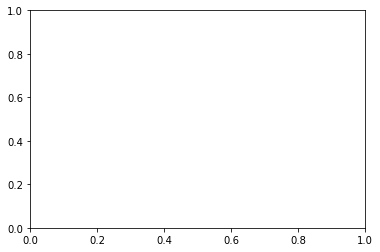

In [25]:
for m in model_run_control_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(fg_co2[m]['fgco2'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total ocean sink, kg/yr')

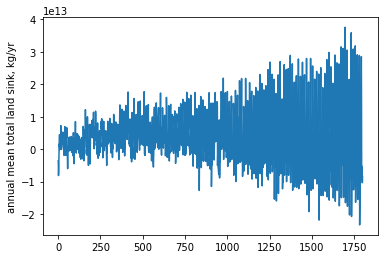

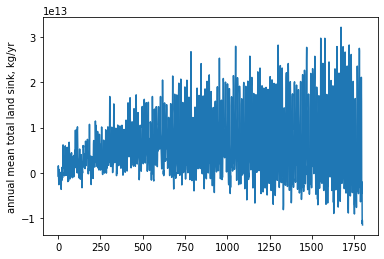

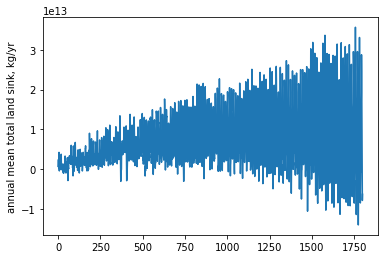

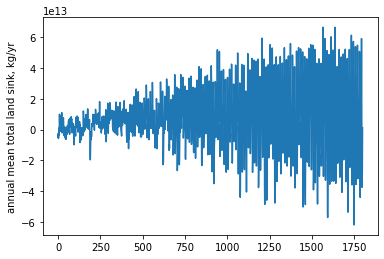

In [82]:
for m in model_run_control_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total land sink, kg/yr')

Text(0, 0.5, 'annual mean total sinks, kg')

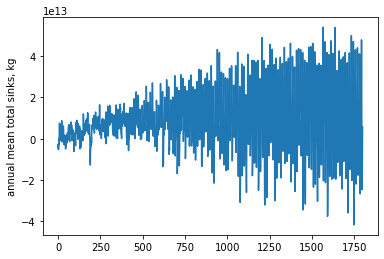

In [19]:
plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['lat','lon']))
plt.ylabel('annual mean total sinks, kg')

In [26]:
emis_sinks = {}
for m in model_run_control_dict.keys():
    emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['lat','lon'])

In [33]:
for m in model_run_control_dict.keys():
    print(m)
    times = pd.date_range('2000', periods=len(emis_sinks[m]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', emis_sinks[m]['time'].values)]).astype('float')
    emis_sinks[m] =  (emis_sinks[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


UKESM1
MIROC
NORESM2
GFDL


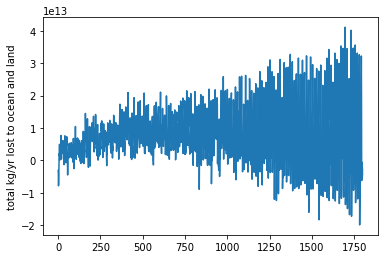

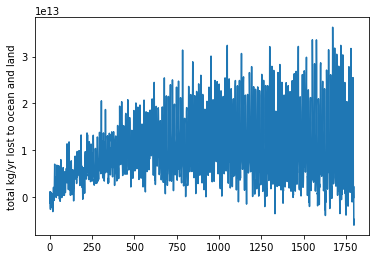

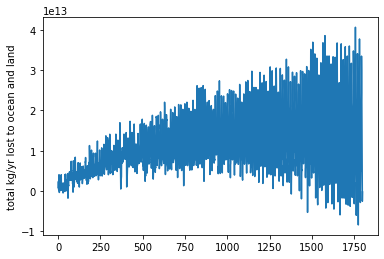

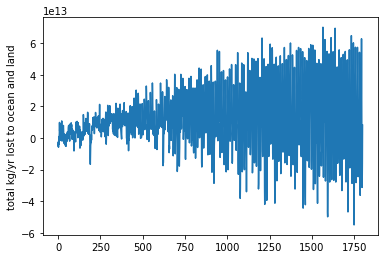

In [127]:
for m in model_run_control_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_sinks[m])
    plt.ylabel('total kg/yr lost to ocean and land')

In [28]:
G_atm = {}
for m in model_run_control_dict.keys():
    if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
        times = pd.date_range('2000', periods=len(co2_dif[m]['time']), freq='MS')
        weights = times.shift(1, 'MS') - times
        weights = xr.DataArray(weights, [('time', co2_dif[m]['time'].values)]).astype('float')

        G_atm[m] = (co2_dif[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


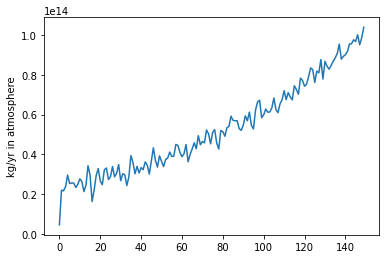

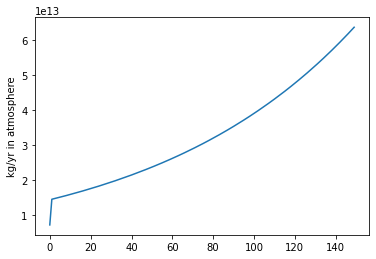

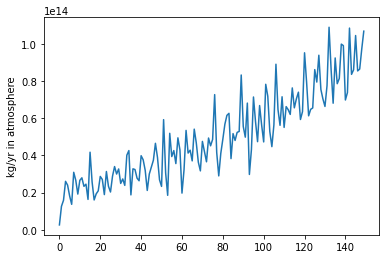

In [29]:
for m in model_run_control_dict.keys():
    if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
        fig, ax = plt.subplots()
        plt.plot(G_atm[m])
        plt.ylabel('kg/yr in atmosphere')

In [34]:
emis_co2 = {}
emis_co2_rolling10 = {}
emis_co2_rolling20 = {}

for m in model_run_control_dict.keys():
    if m == 'UKESM1' or m == 'NORESM2' or m == 'GFDL':
        emis_co2[m] = G_atm[m] + emis_sinks[m]
        emis_co2_rolling10[m] = G_atm[m].rolling(year = 10).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 10).mean(center = True).dropna("year")
        emis_co2_rolling20[m] = G_atm[m].rolling(year = 20).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 20).mean(center = True).dropna("year")
    elif m == 'MIROC':
        emis_co2[m] = G_atm['NORESM2'] + emis_sinks[m]
        emis_co2_rolling10[m] = G_atm['NORESM2'].rolling(year = 10).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 10).mean(center = True).dropna("year")
        emis_co2_rolling20[m] = G_atm['NORESM2'].rolling(year = 20).mean(center = True).dropna("year") + emis_sinks[m].rolling(year = 20).mean(center = True).dropna("year")
    
    

In [35]:
kg_CO2_to_GtC = 1/(1e12*3.67)

In [37]:
emis_co2_GtC = {}
emis_co2_GtC_rolling10 = {}
emis_co2_GtC_rolling20 = {}

for m in model_run_control_dict.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_CO2_to_GtC
    emis_co2_GtC_rolling10[m] = emis_co2_rolling10[m]*kg_CO2_to_GtC
    emis_co2_GtC_rolling20[m] = emis_co2_rolling20[m]*kg_CO2_to_GtC

emis_co2_ds =  ((np.array(G_atm_1pct_ds['co2_response'])/kg_to_Gt)[...,None,None] + 
        fg_co2_ds['fgco2'].isel(time = slice(0,len(G_atm_1pct_ds['co2_response']))) + 
        nbp_ds['nbp'].isel(time = slice(0,len(G_atm_1pct_ds['co2_response']))))

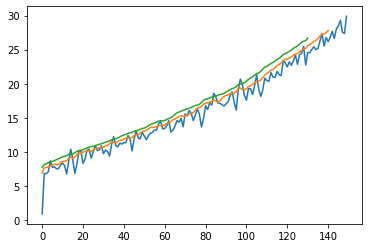

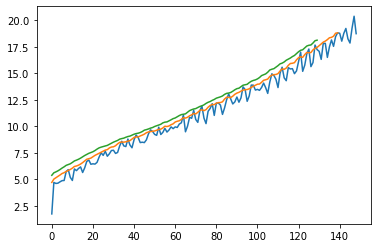

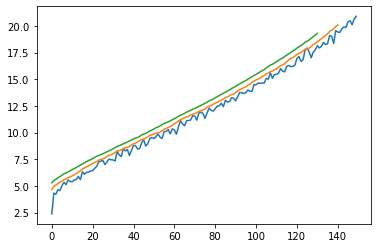

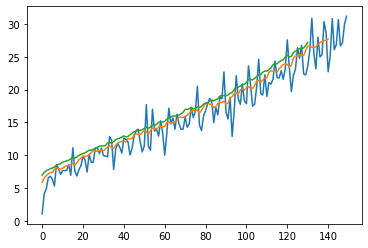

In [39]:
for m in model_run_control_dict.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_co2_GtC[m]) #Gt/yr
    plt.plot(emis_co2_GtC_rolling10[m]) #Gt/yr
    plt.plot(emis_co2_GtC_rolling20[m]) #Gt/yr

In [46]:
for m in model_run_control_dict.keys():
    emis_co2_GtC[m]['year'] = np.arange(0,len(emis_co2_GtC[m]['year']))
    emis_co2_GtC_rolling10[m]['year'] = np.arange(0,len(emis_co2_GtC_rolling10[m]['year']))
    emis_co2_GtC_rolling20[m]['year'] = np.arange(0,len(emis_co2_GtC_rolling20[m]['year']))

In [48]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')
emis_co2_GtC_rolling10_ds = xr.concat([emis_co2_GtC_rolling10[m] for m in emis_co2_GtC_rolling10.keys()], pd.Index([m for m in emis_co2_GtC_rolling10.keys()], name='model'), coords='minimal')
emis_co2_GtC_rolling20_ds = xr.concat([emis_co2_GtC_rolling20[m] for m in emis_co2_GtC_rolling20.keys()], pd.Index([m for m in emis_co2_GtC_rolling20.keys()], name='model'), coords='minimal')


# Save out CO2 emissions

In [49]:
emis_co2_GtC_ds.to_netcdf('1pct_emis_profile.nc4')
emis_co2_GtC_rolling10_ds.to_netcdf('1pct_emis_profile_rolling10.nc4')
emis_co2_GtC_rolling20_ds.to_netcdf('1pct_emis_profile_rolling20.nc4')

#np.savetxt('1pct_emis_profile_derived.csv', np.array(list(E_base.values())), delimiter=',')
#np.savetxt('1pct_emis_profile_rcp85.csv', np.array(list(E_85.values())), delimiter=',')
np.savetxt('1pct_emis_profile.csv', np.array(emis_co2_GtC_ds))
np.savetxt('1pct_emis_profile_rolling10.csv', np.array(emis_co2_GtC_rolling10_ds))
np.savetxt('1pct_emis_profile_rolling20.csv', np.array(emis_co2_GtC_rolling20_ds))